In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
import cv2
import numpy as np


import os

## Settings

In [2]:
root_dir = 'archive'
batch_size = 30
n_epoch = 20
cuda = True

n_classes = 20

In [3]:
labels_dir = {
    'buffalo': 0,
    'elephant': 1,
    'rhino': 2,
    'zebra': 3,
}
inv_labels_dir = {v: k for k, v in labels_dir.items()}

## Dataset part

In [4]:
class MotyaDataset(Dataset):
    """Motyas dataset."""

    def __init__(self, root_dir, val=False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        classes_dir = [f for f in os.listdir(root_dir)]
        all_files = []
        classes = []
        for class_dir in classes_dir:
            files = [class_dir + '/' + f for f in os.listdir(root_dir + '/' + class_dir) if f.endswith('.jpg')]
            all_files += files
            classes += [class_dir]*len(files)
            
                
        # Validation split
        split = int(len(all_files)*0.8)
        if val == False:
            self.files = all_files[:split]
            self.classes = classes[:split]
        else:
            self.files = all_files[split:]
            self.classes = classes[split:]
            
        

    def __len__(self):
        return len( self.files)
    

    def __getitem__(self, idx):        
        path = self.files[idx][:-4]
        img_class = self.classes[idx]
        
        # Loading image
        image = plt.imread(self.root_dir + '/' + path + '.jpg')
        image = (2.0 * image / 255) - 1.0        
        image = cv2.resize(image, (300, 300))
        image = np.moveaxis(image, 2, 0)
        
        #Loading nuber of animals
        txt_data = open(self.root_dir + '/' + path + '.txt', 'r').readlines()
        animals_n = len(txt_data)

        return image, labels_dir[img_class]   #, animals_n    #animals_n     #labels_dir[img_class], 

In [5]:
b = MotyaDataset(root_dir)
x = b.__getitem__(0)

In [6]:
train_loader = DataLoader(MotyaDataset(root_dir), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MotyaDataset(root_dir, val=True), batch_size=batch_size, shuffle=True)

In [7]:
for x in train_loader:
    print(x[1].shape)
    break

torch.Size([30])


In [8]:
x[1]

tensor([0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 3, 2, 0, 2, 1, 0, 2, 2, 1,
        0, 1, 0, 0, 0, 1])

tensor(0.0017, dtype=torch.float64) tensor(0.9765, dtype=torch.float64)


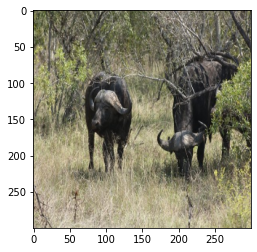

In [9]:
im = x[0][0].permute(1,2,0)
im =  (im + 1)/2

print(im.min(), im.max())
plt.imshow(im)

## Model part

In [10]:
class Model(nn.Module):
    def __init__(self, n=4, pre=True):
        super().__init__()
        
        #Encoder for images
        self.enc = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=pre)
        self.enc.fc = nn.Linear(512, 512)

        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512,150),
            nn.ReLU(),
            nn.BatchNorm1d(150),
            #nn.Dropout(0.5),
            nn.Linear(150,n)
        )
        
        
        
    def forward(self, x): 
        x = self.enc(x)

        x = self.head(x)
        
        return x

In [11]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(512, n_classes)

Using cache found in /home/admiral/.cache/torch/hub/pytorch_vision_v0.6.0


In [12]:
model = Model(n_classes)

Using cache found in /home/admiral/.cache/torch/hub/pytorch_vision_v0.6.0


## Tarin part

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)

In [14]:
if cuda:
    model = model.cuda()
model.train()
    
accuracy = []
overall_loss = []
for epoch in range(n_epoch):  # loop over the dataset multiple times

    model.train()  
    epoch_loss = []
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = loss.item()
        epoch_loss.append(running_loss)
        
    epoch_loss_mean = np.array(epoch_loss).mean()
    overall_loss.append(epoch_loss_mean)
    print(f'Epoch: {epoch}, Loss: {epoch_loss_mean}')
            
    model.eval()       
    correct = 0
    total = 0
    with torch.no_grad():
        
        for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
            images, labels = data
            
            if cuda:
                images = images.cuda()
            
            outputs = model(images.float()).cpu().detach()
            predicted = outputs.argmax(1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))

print('Finished Training')

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.920334392786026


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 45 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.441867870092392


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 73 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2, Loss: 2.0089508682489394


 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]


TypeError: unsupported operand type(s) for *: 'float' and 'JpegImageFile'

## Test part

In [ ]:
model = model.eval()

In [ ]:
for image, label in val_loader:
    pred = model(image.float().cuda())
    pred = pred.cpu().argmax(1)
    
    print("GT: ", label)
    print("Pred: ", pred)
    break

In [ ]:
image = plt.imread('archive/elephant/370.jpg')
plt.imshow(image)
image = cv2.resize(image, (300, 300))

image = np.moveaxis(image, 2, 0)

image = (2.0 * image / 255) - 1.0

In [ ]:
test = (torch.tensor(image))
test = torch.unsqueeze(test, 0)

In [ ]:
test.shape

In [ ]:
if cuda:
    test = test.cuda()

print(test.shape)
x = model(test.float())

In [ ]:
x

In [ ]:
inv_labels_dir[x.argmax().item()]

In [ ]:
x.argmax().item()